In [1]:
# imports
import os
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager

from statsmodels.tsa.stattools import adfuller

from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from scipy.special import inv_boxcox
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')

In [2]:
# data prep
path = 'Data/Forecasting/QuarterlyStateBeerReports/'
list_dfs=[]
months = {'Q1': '01', 'Q2': '04', 'Q3': '07', 'Q4': '10'}
for file in os.listdir(path):
    if '~$' not in file:
        # get file
        filename = path + file
        df = pd.read_excel(filename)
        
        # only take Washington record
        df = pd.DataFrame(df[df.iloc[:, 0] == 'Washington'].iloc[:,1])
        
        # get date time
        year = file[:4]
        quarter = file[5:7]
        df['quarter'] = year + quarter
        
        list_dfs.append(df)

# concat data
prod = pd.concat(list_dfs)

# clean up data
prod.rename(columns={'Unnamed: 1': 'production'}, inplace=True)
prod['quarter'] = pd.to_datetime(prod['quarter'], format='mixed')
prod.sort_values(by='quarter', inplace=True)
prod.reset_index(drop=True, inplace=True)
prod = prod[['quarter', 'production']]

# change column types
prod['production'].replace(',','', regex=True, inplace=True)
prod['production'] = pd.to_numeric(prod['production'])

# save data
prod.to_excel('Data/Forecasting/quarterly_beer_reports.xlsx')

# view data
prod.head()

,quarter,production
0,2015-01-01,138240.44
1,2015-04-01,151231.15
2,2015-07-01,161505.20
3,2015-10-01,135659.54
4,2019-01-01,141770.84


In [3]:
# TEMP FILL IN DATA
d = {
    '2016Q1':140639.75,
    '2017Q1':140639.75,
    '2018Q1':140639.75,
    '2016Q1':163443.93,
    '2017Q2':163443.93,
    '2018Q2':163443.93,
    '2016Q3':174996.77,
    '2017Q3':174996.77,
    '2018Q3':174996.77,
    '2016Q4':138930.07,
    '2017Q4':138930.07,
    '2018Q4':138930.07
}
df = pd.DataFrame(d.items(), columns=['quarter', 'production'])

prod = pd.concat([prod, df])

prod['quarter'] = pd.to_datetime(prod['quarter'], format='mixed')
prod.sort_values(by='quarter', inplace=True)
prod.reset_index(drop=True, inplace=True)

prod.head()

,quarter,production
0,2015-01-01,138240.44
1,2015-04-01,151231.15
2,2015-07-01,161505.20
3,2015-10-01,135659.54
4,2016-01-01,163443.93


In [4]:
# visualization settings

# use lato font
font_path = 'Reference/Lato/Lato-Regular.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

# set colors
col_yellow = '#ffa400'
col_green = '#256143'
col_brown = '#9c5421'
col_off_black = '#434343'
mpl.rcParams['text.color'] = col_off_black # title and legend
mpl.rcParams['xtick.color'] = col_off_black # tick marks
mpl.rcParams['ytick.color'] = col_off_black # tick marks
mpl.rcParams['axes.labelcolor'] = col_off_black # axes labels

# set font sizes
mpl.rcParams['axes.titlesize'] = 14 # title
mpl.rcParams['axes.labelsize'] = 12 # axes labels
mpl.rcParams['xtick.labelsize'] = 11 # tick marks
mpl.rcParams['ytick.labelsize'] = 11 # tick marks
mpl.rcParams['legend.title_fontsize'] = 12 # legend title
mpl.rcParams['legend.fontsize'] = 11 # legend text

# set figure size
figsz = (10,6)

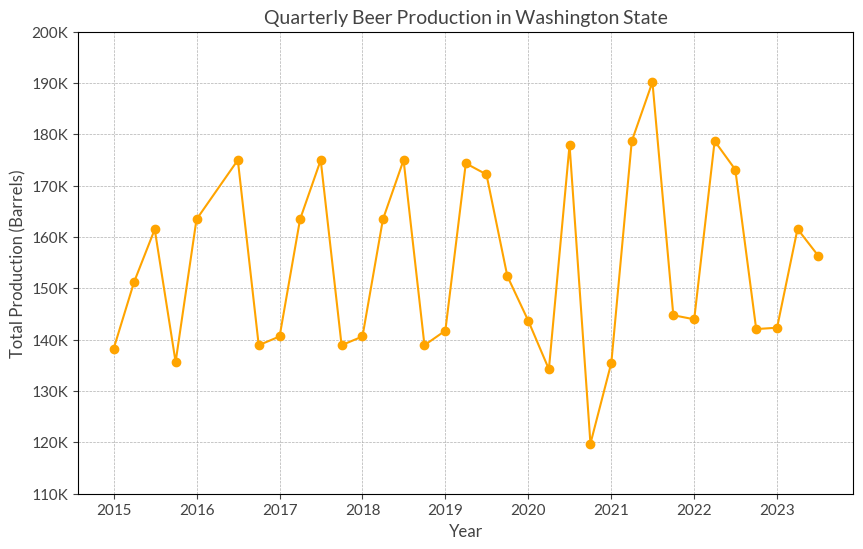

In [5]:
# plot time series
def plot_time_series(df: pd.DataFrame, y: str, y_label: str, adjust_y_labels: bool):
    # general function to plot timeseries data
    
    plt.figure(figsize=figsz)

    plt.plot(df['quarter'], df[y], color=col_yellow, marker='o')

    plt.title('Quarterly Beer Production in Washington State')
    plt.xlabel('Year')
    plt.ylabel(y_label)

    if adjust_y_labels == True:
        ylocs, ylabels = plt.yticks() 
        ylabels_new = ['{:,.0f}'.format(x) + 'K' for x in ylocs/1000]
        plt.yticks(ylocs, ylabels_new)

    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.grid(axis='x', linestyle='--', linewidth=0.5)

plot_time_series(df=prod, y='production', y_label='Total Production (Barrels)',
                adjust_y_labels=True)

Augmented Dickey-Fuller Test

uition behind a unit root test is that it determines how strongly a time series is defined by a trend.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

In [6]:
# test if data is stationary: Augmented Dickey-Fuller Test
adft = adfuller(prod['production'])

# results
test_stat = adft[0]
p_val = adft[1]
critical_vals = adft[4].items()

reject_null, reject_lang = ('reject', 'conclude') if p_val < 0.05 else ('not reject', 'not conclude')

# print results
print('ADF Test Statistic: %f' % test_stat)
print('p-value: %f' % p_val)
print('Critical Values:')
for key, value in critical_vals:
    print('\t%s: %.3f' % (key, value))
print('We can %s the Null Hypothesis and %s that the time series is stationary.' % (reject_null, reject_lang))

ADF Test Statistic: -3.048570
p-value: 0.030601
Critical Values:
	1%: -3.753
	5%: -2.998
	10%: -2.639
We can reject the Null Hypothesis and conclude that the time series is stationary.


EXPLAIN BOXCOX

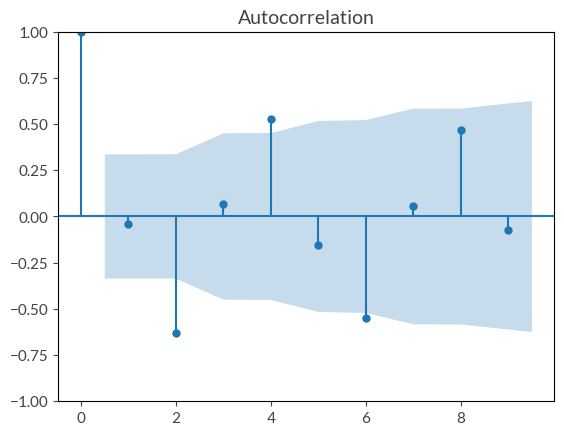

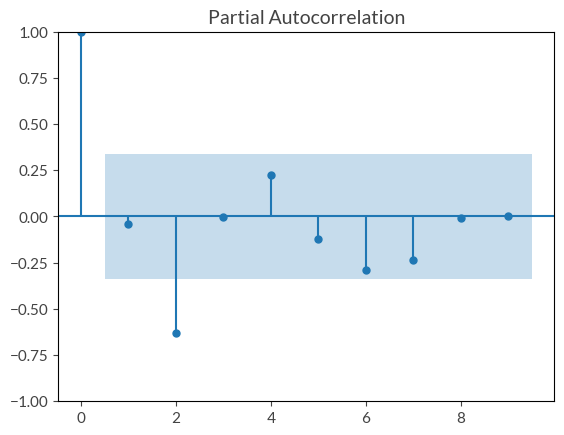

In [7]:
# make data stationary if required
if reject_null != 'reject':
    # Box-Cox Transformation
    prod['production_boxcox']
    prod['production_diff'] = prod['production_boxcox'].diff()
    lam = boxcox(prod['production'])
    prod.dropna(inplace=True)

    # plot stationary data
    plot_time_series(df=prod, y='production_diff', y_label='Total Production Diff (Barrels)',
                    adjust_y_labels=False)
    
    # plot ACF and PACF
    plot_acf(prod['production_diff'], lags=9)
    plot_pacf(prod['production_diff'], method='ywm', lags=9)
    plt.show()
    
    # variable to use for analysis
    model_var = 'production_boxcox'

else:
    # plot ACF and PACF
    plot_acf(prod['production'], lags=9)
    plot_pacf(prod['production'], method='ywm', lags=9)
    plt.show()
    
    # variable to use for analysis
    model_var = 'production'  

Different models should be tested. The components of the SARIMA to be tested: ARIMA(p,d,q)(P,D,Q)m

Non-Seasonal Components
- p: autoregressive
- d: difference
- q: moving average

Seasonal Components
- P: seasonal autoregressive
- D: seasonal difference
- Q: seasonal moving average
- m: number of time steps for a single seasonal period.

The lags are also significant around the second lag for both plots. A seasonal value of 2 or 4 may be suitable. A value of 4 would indicate annual trend with quarterly data.

In [8]:
# train and test set 
prod.index = pd.to_datetime(prod['quarter'])
prod.index = prod.index.to_period('Q')
train = prod.iloc[:-int(len(prod) * 0.2)]
test = prod.iloc[-int(len(prod) * 0.2):]

In [9]:
# test different models (original or transformed)

pqtest = [1,2,3,4]
mtest = [2,4]

labels = []
aic = []
bic = []

for p in pqtest:
    for q in pqtest:
        for m in mtest:
            if p < m and q < m:
                model = ARIMA(train[model_var], order=(p,1,q), seasonal_order=(1,1,1,m)).fit()
                labels.append('SARIMA({},1,{})(1,1,1,{})'.format(p,q,m))
                aic.append(model.aic)
                bic.append(model.bic)
            
model_results = pd.DataFrame(
    {'model': labels,
     'aic': aic,
     'bic': bic
    })

model_results.sort_values(by='aic')

,model,aic,bic
4,"SARIMA(2,1,1)(1,1,1,4)",522.932232,529.745197
8,"SARIMA(3,1,2)(1,1,1,4)",524.469818,533.553771
7,"SARIMA(3,1,1)(1,1,1,4)",524.534258,532.482718
2,"SARIMA(1,1,2)(1,1,1,4)",525.612809,532.425775
5,"SARIMA(2,1,2)(1,1,1,4)",526.163608,534.112067
1,"SARIMA(1,1,1)(1,1,1,4)",526.549393,532.226864
3,"SARIMA(1,1,3)(1,1,1,4)",528.707196,536.655655
9,"SARIMA(3,1,3)(1,1,1,4)",530.099455,540.318903
6,"SARIMA(2,1,3)(1,1,1,4)",530.360273,539.444227
0,"SARIMA(1,1,1)(1,1,1,2)",599.712467,605.806846


In [10]:
# best model (lowest AIC, BIC)
model = ARIMA(train[model_var], order=(2,1,1), seasonal_order=(1,1,1,4)).fit()

In [11]:
# 5-year forecast
forecast_len = len(test) + 20 # quarterly data * 5 years after test data
if reject_null != 'reject':
    boxcox_forecasts = model.forecast(forecast_len)
    forecasts = inv_boxcox(boxcox_forecasts, lam) # reverse back to original production values
else:
    forecasts = model.forecast(forecast_len)
    
# fix forecast
forecasts = forecasts.shift(1, freq='Q')
    
# get length of forecasts for plotting
forecasts_plot = forecasts[0:len(test)]

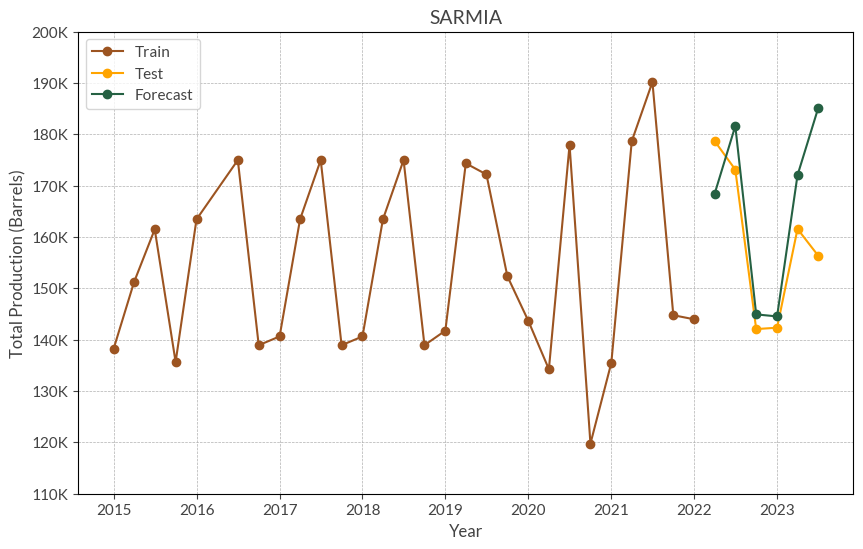

In [12]:
# plot forecasts
plt.figure(figsize=figsz)

plt.plot(train['quarter'], train['production'], color=col_brown, marker='o', label='Train')
plt.plot(test['quarter'], test['production'], color=col_yellow, marker='o', label='Test')
plt.plot(test['quarter'], forecasts_plot, color=col_green, marker='o', label='Forecast')

plt.title('SARMIA')
plt.xlabel('Year')
plt.ylabel('Total Production (Barrels)')
plt.legend()

ylocs, ylabels = plt.yticks() 
ylabels_new = ['{:,.0f}'.format(x) + 'K' for x in ylocs/1000]
plt.yticks(ylocs, ylabels_new)

plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.grid(axis='x', linestyle='--', linewidth=0.5)

In [13]:
# five year forecast
forecasts[len(test):]

2023Q4    149035.794010
2024Q1    148794.114297
2024Q2    176862.247196
2024Q3    190174.723227
2024Q4    154571.664088
2025Q1    154559.237522
2025Q2    182946.821346
2025Q3    196453.449026
2025Q4    161077.028926
2026Q1    161224.777933
2026Q2    189780.936156
2026Q3    203416.271499
2026Q4    168166.792067
2027Q1    168416.260016
2027Q2    197068.604591
2027Q3    210783.612561
2027Q4    175607.481691
2028Q1    175919.016125
2028Q2    204627.539985
2028Q3    218390.729184
Freq: Q-DEC, Name: predicted_mean, dtype: float64